# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [17]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [18]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh', gpu = False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        self.gpu = gpu
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
        
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
        if self.gpu:
            self.Xmeans = self.Xmeans.to('cuda')
            self.Xstds = self.Xstds.to('cuda')
            self.Tmeans = self.Tmeans.to('cuda')
            self.Tstds = self.Tstds.to('cuda')
            X = X.to('cuda')
            T = T.to('cuda')        

        

        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
       
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        epochs_per_print = n_epochs // 10
        for epoch in range(n_epochs):
            Y = self.forward(X)        
    
            mse = mse_func(T, Y)
            mse.backward()
            #pdb.set_trace()
            error_convert_f = lambda err: (torch.sqrt(err) * self.Tstds)[0] # to scalar
            error = error_convert_f(mse)
            self.error_trace.append(error)
#             error_trace =error_trace.detach().numpy()
            optimizer.step() 
            optimizer.zero_grad()
            
            if self.gpu:
                if (epoch + 1) % max(1, epochs_per_print) == 0:
                    print(f'Epoch {epoch+1:d} Error|={error.cpu().detach().numpy():.5f}')
            else:
                if (epoch + 1) % max(1, epochs_per_print) == 0:
                    print(f'Epoch {epoch+1:d} Error|={error.detach().numpy():.5f}')

    def use(self, X):
        
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
            if self.gpu:
                X = torch.tensor(X).to('cuda')
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y_un = self.forward(X)
        Y = (Y_un*self.Tstds) + self.Tmeans
#         print(Y)
        
        # Return output Y after detaching from computation graph and converting to numpy
        if self.gpu:
            return Y.cpu().detach().numpy()
        else:
            return Y.detach().numpy()

## Example

In [19]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5 Error|=11.15545
Epoch 10 Error|=6.06195
Epoch 15 Error|=5.16921
Epoch 20 Error|=2.10268
Epoch 25 Error|=2.31699
Epoch 30 Error|=2.63575
Epoch 35 Error|=1.46300
Epoch 40 Error|=1.13660
Epoch 45 Error|=1.17029
Epoch 50 Error|=0.92157
RMSE 0.867


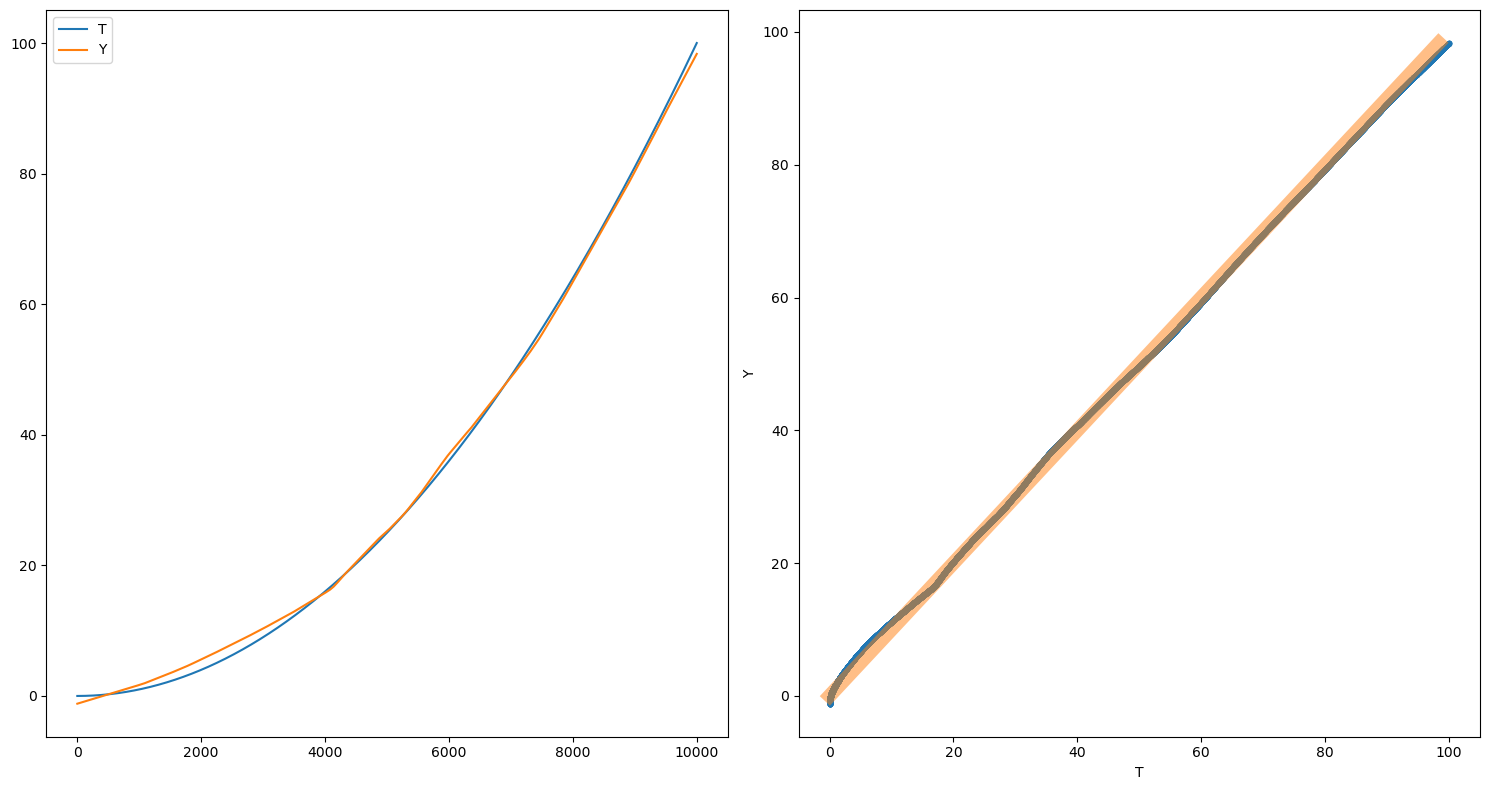

In [20]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [21]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [22]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [23]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [24]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func,gpu=False):
    results=[]
    
    for hidden_units in list_of_n_hiddens:
    #                     net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
    #                     net.train(X, T, 50, 0.01)
        rmse_train = 0
        rmse_val = 0
        rmse_test = 0
        for  Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            if gpu:
                nnet = NNet(Xtrain.shape[1], hidden_units,Ttrain.shape[1],act_func=act_func, gpu=True)
                nnet.cuda()
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)
                

            else:
                nnet = NNet(Xtrain.shape[1], hidden_units,Ttrain.shape[1],act_func=act_func)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)

            rmse_train += rmse(Ttrain, nnet.use(Xtrain))
            rmse_val += rmse(Tvalidate, nnet.use(Xvalidate))
            rmse_test += rmse(Ttest, nnet.use(Xtest))




        results.append([ hidden_units,
                                rmse_train/n_folds,
                               rmse_val/n_folds,
                                rmse_test/n_folds])
    df = pandas.DataFrame(results, columns=('Arch','train RMSE',
                                                'validate RMSE', 'RMSE Test'))
    #         print(df)  
    return df

    
    
    
#     for (list_of_n_hiddens,n_epochs,learning_rate,act_func) in product(list_of_n_hiddens,n_epochs,learning_rate,act_func):
#         print(list_of_n_hiddens,n_epochs,learning_rate,act_func)

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [25]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))
T =airfoil.iloc[:,5:6].values
X =airfoil.iloc[:,0:5].values

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [26]:
X.shape, T.shape

((1503, 5), (1503, 1))

In [27]:
results=[]

In [28]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
#print(f'Took {elapsed:.2f} hours')
#results

Epoch 20 Error|=7.08664
Epoch 40 Error|=6.10765
Epoch 60 Error|=5.54745
Epoch 80 Error|=5.20149
Epoch 100 Error|=5.01565
Epoch 120 Error|=4.92485
Epoch 140 Error|=4.88381
Epoch 160 Error|=4.86612
Epoch 180 Error|=4.85866
Epoch 200 Error|=4.85558
Epoch 20 Error|=7.67340
Epoch 40 Error|=6.21070
Epoch 60 Error|=5.39083
Epoch 80 Error|=5.03569
Epoch 100 Error|=4.91447
Epoch 120 Error|=4.88240
Epoch 140 Error|=4.87614
Epoch 160 Error|=4.87531
Epoch 180 Error|=4.87523
Epoch 200 Error|=4.87520
Epoch 20 Error|=7.47603
Epoch 40 Error|=6.27370
Epoch 60 Error|=5.51613
Epoch 80 Error|=5.10855
Epoch 100 Error|=4.91502
Epoch 120 Error|=4.83382
Epoch 140 Error|=4.80426
Epoch 160 Error|=4.79498
Epoch 180 Error|=4.79243
Epoch 200 Error|=4.79179
Epoch 20 Error|=5.08506
Epoch 40 Error|=4.81216
Epoch 60 Error|=4.78943
Epoch 80 Error|=4.77051
Epoch 100 Error|=4.76297
Epoch 120 Error|=4.75958
Epoch 140 Error|=4.75835
Epoch 160 Error|=4.75795
Epoch 180 Error|=4.75785
Epoch 200 Error|=4.75783
Epoch 20 Error|=

Epoch 40 Error|=4.67724
Epoch 60 Error|=4.46554
Epoch 80 Error|=4.42406
Epoch 100 Error|=4.41986
Epoch 120 Error|=4.41887
Epoch 140 Error|=4.41791
Epoch 160 Error|=4.41707
Epoch 180 Error|=4.41633
Epoch 200 Error|=4.41569
Epoch 20 Error|=6.40064
Epoch 40 Error|=5.60998
Epoch 60 Error|=5.12254
Epoch 80 Error|=4.88557
Epoch 100 Error|=4.77870
Epoch 120 Error|=4.70648
Epoch 140 Error|=4.65331
Epoch 160 Error|=4.61391
Epoch 180 Error|=4.58372
Epoch 200 Error|=4.56025
Epoch 20 Error|=7.80063
Epoch 40 Error|=6.19943
Epoch 60 Error|=5.26735
Epoch 80 Error|=4.82633
Epoch 100 Error|=4.63146
Epoch 120 Error|=4.56393
Epoch 140 Error|=4.54614
Epoch 160 Error|=4.54035
Epoch 180 Error|=4.53653
Epoch 200 Error|=4.53321
Epoch 20 Error|=7.49809
Epoch 40 Error|=6.65453
Epoch 60 Error|=6.11566
Epoch 80 Error|=5.54892
Epoch 100 Error|=5.10262
Epoch 120 Error|=4.84335
Epoch 140 Error|=4.71542
Epoch 160 Error|=4.64896
Epoch 180 Error|=4.60486
Epoch 200 Error|=4.56965
Epoch 20 Error|=9.03702
Epoch 40 Error|=

Epoch 120 Error|=1.58024
Epoch 140 Error|=1.37768
Epoch 160 Error|=1.46598
Epoch 180 Error|=1.17588
Epoch 200 Error|=1.10508
Epoch 20 Error|=4.70518
Epoch 40 Error|=3.76244
Epoch 60 Error|=3.37410
Epoch 80 Error|=2.92637
Epoch 100 Error|=2.44959
Epoch 120 Error|=2.02081
Epoch 140 Error|=1.70268
Epoch 160 Error|=1.50981
Epoch 180 Error|=1.39511
Epoch 200 Error|=1.29554
Epoch 20 Error|=4.63525
Epoch 40 Error|=3.75897
Epoch 60 Error|=3.29650
Epoch 80 Error|=2.78280
Epoch 100 Error|=2.15716
Epoch 120 Error|=1.72554
Epoch 140 Error|=1.48574
Epoch 160 Error|=1.34043
Epoch 180 Error|=1.26238
Epoch 200 Error|=1.18791
Epoch 20 Error|=4.90707
Epoch 40 Error|=3.77930
Epoch 60 Error|=3.31519
Epoch 80 Error|=2.81495
Epoch 100 Error|=2.26817
Epoch 120 Error|=1.82816
Epoch 140 Error|=1.56233
Epoch 160 Error|=1.41184
Epoch 180 Error|=1.30327
Epoch 200 Error|=1.21761
Epoch 20 Error|=4.68143
Epoch 40 Error|=3.82127
Epoch 60 Error|=3.38130
Epoch 80 Error|=3.00447
Epoch 100 Error|=2.64284
Epoch 120 Error|

In [29]:
results

,Arch,train RMSE,validate RMSE,RMSE Test
0,[],19.162046,19.356871,19.362970
1,[1],18.078123,18.201496,18.176012
2,[5],15.781155,16.301123,16.225892
3,"[200, 200]",4.909889,7.276401,7.203766


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [30]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

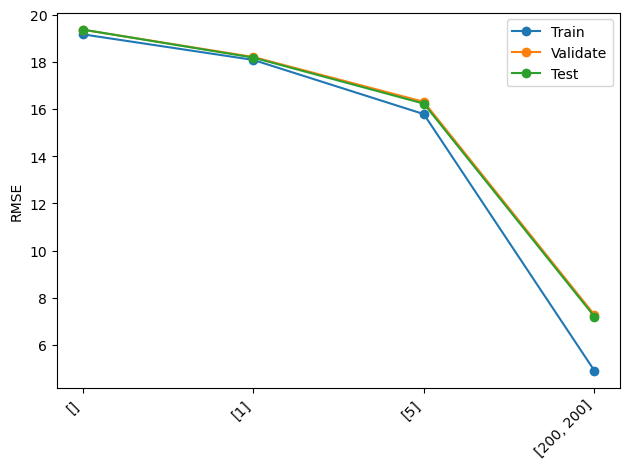

In [31]:
plot_results(results)

<h4>Discussion / Observation</h4>

<P>I have initially experienced difficulties in running tests on CPU due to its time-consuming nature, as a single 5000 epoch experiment took almost 30 minutes to complete. In order to conduct more extensive tests with lower learning rates and larger networks, which demand a significantly greater number of epochs to train, I had to download CUDA and make the necessary modifications to harness the power of the GPU. This change resulted in an immediate and substantial improvement in performance, with the GPU capable of training networks with over double the number of epochs in half the time compared to the CPU.
</P>
<P>
Regarding the parameters used during the experiments, I observed that larger networks with symmetrical layers yielded lower RMSEs (Root Mean Square Errors). This observation was possible by running multiple sets of experiments while adjusting the GPU integration and output. However, the three multilayer networks seemed to require a substantially higher number of epochs for validation and test errors to converge closer to the training error. Additionally, I have done experiments by lowering the learning rate on experiments with more epochs, but this change appeared to be minimal which has no effect on the results.
</P>
<P>
I can acknowledge that finding the optimal learning rate would likely be necessary for experimentation and fine-tuning. To achieve this, I would create a multilayer loop to sequentially reconfigure the network parameters in order to optimize the errors. 
</P>
<P>
In conclusion, the majority of the networks performed well, with even single-layer networks demonstrating strong results when tested with a greater number of nodes. This highlights the potential for further optimization and exploration of network configurations in the pursuit of improved performance
</P>

# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [32]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'karra-A3.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook karra-A3.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]

Epoch 10 Error|=0.87483
Epoch 20 Error|=0.69854
Epoch 30 Error|=0.42182
Epoch 40 Error|=0.36691
Epoch 50 Error|=0.27834
Epoch 60 Error|=0.23354
Epoch 70 Error|=0.21923
Epoch 80 Error|=0.20792
Epoch 90 Error|=0.19651
Epoch 100 Error|=0.18570

--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]

Epoch 10 Error|=0.49414
Epoch 20 Error|=0.44816
Epoch 30 Error|=0.36444
Epoch 40 Error|=0.31577
Epoch 50 Error|=0.

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).

In [34]:
import time

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5],[50,50],[100,100],[200,300], [200,300,100],[200,300,100,50]],
                                      400, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
results.append(results)

torch.manual_seed(42)
np.random.seed(42)

start = time.time()
results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5],[50,50],[100,100],[200,300], [200,300,100],[200,300,100,50]],
                                      400, 0.01, 'tanh',gpu =True)

elapsed2 = (time.time() - start) / 60/ 60
print(f'Took {elapsed2:.2f} hours on GPU')
results.append(results)

Epoch 40 Error|=0.49774
Epoch 80 Error|=0.26515
Epoch 120 Error|=0.12809
Epoch 160 Error|=0.07127
Epoch 200 Error|=0.05947
Epoch 240 Error|=0.05837
Epoch 280 Error|=0.05832
Epoch 320 Error|=0.05831
Epoch 360 Error|=0.05831
Epoch 400 Error|=0.05831
Epoch 40 Error|=0.43342
Epoch 80 Error|=0.25156
Epoch 120 Error|=0.24388
Epoch 160 Error|=0.24380
Epoch 200 Error|=0.24380
Epoch 240 Error|=0.24380
Epoch 280 Error|=0.24380
Epoch 320 Error|=0.24380
Epoch 360 Error|=0.24380
Epoch 400 Error|=0.24380
Epoch 40 Error|=0.24703
Epoch 80 Error|=0.24461
Epoch 120 Error|=0.24459
Epoch 160 Error|=0.24459
Epoch 200 Error|=0.24459
Epoch 240 Error|=0.24459
Epoch 280 Error|=0.24459
Epoch 320 Error|=0.24459
Epoch 360 Error|=0.24459
Epoch 400 Error|=0.24459
Epoch 40 Error|=0.52509
Epoch 80 Error|=0.26143
Epoch 120 Error|=0.21573
Epoch 160 Error|=0.21426
Epoch 200 Error|=0.21426
Epoch 240 Error|=0.21426
Epoch 280 Error|=0.21426
Epoch 320 Error|=0.21426
Epoch 360 Error|=0.21426
Epoch 400 Error|=0.21426
Epoch 40

Epoch 240 Error|=0.23059
Epoch 280 Error|=0.21376
Epoch 320 Error|=0.19871
Epoch 360 Error|=0.18523
Epoch 400 Error|=0.17329
Epoch 40 Error|=0.87982
Epoch 80 Error|=0.61190
Epoch 120 Error|=0.36501
Epoch 160 Error|=0.25158
Epoch 200 Error|=0.21821
Epoch 240 Error|=0.20000
Epoch 280 Error|=0.18586
Epoch 320 Error|=0.17460
Epoch 360 Error|=0.16553
Epoch 400 Error|=0.15815
Epoch 40 Error|=0.16498
Epoch 80 Error|=0.13252
Epoch 120 Error|=0.12410
Epoch 160 Error|=0.11646
Epoch 200 Error|=0.10957
Epoch 240 Error|=0.10354
Epoch 280 Error|=0.09837
Epoch 320 Error|=0.09398
Epoch 360 Error|=0.09027
Epoch 400 Error|=0.08711
Epoch 40 Error|=0.77933
Epoch 80 Error|=0.64635
Epoch 120 Error|=0.60011
Epoch 160 Error|=0.55728
Epoch 200 Error|=0.52391
Epoch 240 Error|=0.49734
Epoch 280 Error|=0.47385
Epoch 320 Error|=0.45014
Epoch 360 Error|=0.42254
Epoch 400 Error|=0.38648
Epoch 40 Error|=1.06158
Epoch 80 Error|=0.83571
Epoch 120 Error|=0.63080
Epoch 160 Error|=0.54119
Epoch 200 Error|=0.47491
Epoch 24

Epoch 160 Error|=0.03591
Epoch 200 Error|=0.02588
Epoch 240 Error|=0.02046
Epoch 280 Error|=0.01673
Epoch 320 Error|=0.01393
Epoch 360 Error|=0.01181
Epoch 400 Error|=0.01020
Epoch 40 Error|=0.12023
Epoch 80 Error|=0.03263
Epoch 120 Error|=0.01838
Epoch 160 Error|=0.01206
Epoch 200 Error|=0.00846
Epoch 240 Error|=0.00659
Epoch 280 Error|=0.00540
Epoch 320 Error|=0.00452
Epoch 360 Error|=0.00386
Epoch 400 Error|=0.00336
Epoch 40 Error|=0.20690
Epoch 80 Error|=0.07416
Epoch 120 Error|=0.03860
Epoch 160 Error|=0.02567
Epoch 200 Error|=0.01950
Epoch 240 Error|=0.01554
Epoch 280 Error|=0.01264
Epoch 320 Error|=0.01044
Epoch 360 Error|=0.00877
Epoch 400 Error|=0.00750
Epoch 40 Error|=0.26463
Epoch 80 Error|=0.07883
Epoch 120 Error|=0.02971
Epoch 160 Error|=0.01996
Epoch 200 Error|=0.01489
Epoch 240 Error|=0.01203
Epoch 280 Error|=0.01023
Epoch 320 Error|=0.00891
Epoch 360 Error|=0.00787
Epoch 400 Error|=0.00703
Epoch 40 Error|=0.19358
Epoch 80 Error|=0.05537
Epoch 120 Error|=0.03063
Epoch 16

Epoch 240 Error|=0.00240
Epoch 280 Error|=0.00206
Epoch 320 Error|=0.00179
Epoch 360 Error|=0.00159
Epoch 400 Error|=0.00144
Epoch 40 Error|=0.10168
Epoch 80 Error|=0.01459
Epoch 120 Error|=0.00479
Epoch 160 Error|=0.00344
Epoch 200 Error|=0.00262
Epoch 240 Error|=0.00213
Epoch 280 Error|=0.00182
Epoch 320 Error|=0.00162
Epoch 360 Error|=0.00146
Epoch 400 Error|=0.00133
Epoch 40 Error|=0.12945
Epoch 80 Error|=0.01760
Epoch 120 Error|=0.00563
Epoch 160 Error|=0.00428
Epoch 200 Error|=0.00344
Epoch 240 Error|=0.00277
Epoch 280 Error|=0.00227
Epoch 320 Error|=0.00191
Epoch 360 Error|=0.00164
Epoch 400 Error|=0.00143
Epoch 40 Error|=0.16657
Epoch 80 Error|=0.02920
Epoch 120 Error|=0.00910
Epoch 160 Error|=0.00583
Epoch 200 Error|=0.00441
Epoch 240 Error|=0.00357
Epoch 280 Error|=0.00301
Epoch 320 Error|=0.00260
Epoch 360 Error|=0.00228
Epoch 400 Error|=0.00203
Epoch 40 Error|=0.15182
Epoch 80 Error|=0.01689
Epoch 120 Error|=0.00637
Epoch 160 Error|=0.00405
Epoch 200 Error|=0.00294
Epoch 24

Epoch 280 Error|=0.00000
Epoch 320 Error|=0.00000
Epoch 360 Error|=0.00000
Epoch 400 Error|=0.00000
Epoch 40 Error|=0.15102
Epoch 80 Error|=0.01648
Epoch 120 Error|=0.00435
Epoch 160 Error|=0.00276
Epoch 200 Error|=0.00234
Epoch 240 Error|=0.00202
Epoch 280 Error|=0.00176
Epoch 320 Error|=0.00155
Epoch 360 Error|=0.00137
Epoch 400 Error|=0.00122
Epoch 40 Error|=0.17453
Epoch 80 Error|=0.01344
Epoch 120 Error|=0.00262
Epoch 160 Error|=0.00150
Epoch 200 Error|=0.00098
Epoch 240 Error|=0.00060
Epoch 280 Error|=0.00034
Epoch 320 Error|=0.00018
Epoch 360 Error|=0.00010
Epoch 400 Error|=0.00007
Epoch 40 Error|=0.21506
Epoch 80 Error|=0.01426
Epoch 120 Error|=0.00148
Epoch 160 Error|=0.00075
Epoch 200 Error|=0.00057
Epoch 240 Error|=0.00045
Epoch 280 Error|=0.00038
Epoch 320 Error|=0.00033
Epoch 360 Error|=0.00031
Epoch 400 Error|=0.00029
Epoch 40 Error|=0.04168
Epoch 80 Error|=0.00710
Epoch 120 Error|=0.00128
Epoch 160 Error|=0.00089
Epoch 200 Error|=0.00079
Epoch 240 Error|=0.00070
Epoch 28

/var/folders/9b/nsfxppj52z5gfzm9402l24w80000gn/T/ipykernel_5632/118791557.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results.append(results)


AssertionError: Torch not compiled with CUDA enabled